In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

import xgboost as xgb

## Importing the dataset and previewing

In [2]:
df=pd.read_csv('apple_iphone_11_reviews.csv')

In [3]:
df.head()

index                         product                    helpful_count  \
0      0  Apple iPhone XR (64GB) - Black  5,087 people found this helpful   
1      1  Apple iPhone XR (64GB) - Black  2,822 people found this helpful   
2      2  Apple iPhone XR (64GB) - Black  1,798 people found this helpful   
3      3  Apple iPhone XR (64GB) - Black  1,366 people found this helpful   
4      4  Apple iPhone XR (64GB) - Black    536 people found this helpful   

   total_comments                                                url  \
0              24  https://www.amazon.in/Apple-iPhone-XR-64GB-Bla...   
1               6  https://www.amazon.in/Apple-iPhone-XR-64GB-Bla...   
2               0  https://www.amazon.in/Apple-iPhone-XR-64GB-Bla...   
3              14  https://www.amazon.in/Apple-iPhone-XR-64GB-Bla...   
4               5  https://www.amazon.in/Apple-iPhone-XR-64GB-Bla...   

  review_country reviewed_at  \
0         India   2018-12-12   
1         India   2018-11-17   
2         India   2019-01-27   
3         India   2019-05-02   
4         India   2019-05-24   

                                         review_text       review_rating  \
0                                              NOTE:  3.0 out of 5 stars   
1  Very bad experience with this iPhone xr phone....  1.0 out of 5 stars   
2  Amazing phone with amazing camera coming from ...  5.0 out of 5 stars   
3  So I got the iPhone XR just today. The product...  1.0 out of 5 stars   
4  I've been an android user all my life until I ...  5.0 out of 5 stars   

  product_company     profile_name  \
0           Apple     Sameer Patil   
1           Apple  Amazon Customer   
2           Apple                A   
3           Apple    Shubham Dutta   
4           Apple     Nepuni Lokho   

                                        review_title  
0  Which iPhone you should Purchase ? iPhone 8, X...  
1                   Don't buy iPhone xr from Amazon.  
2                            Happy with the purchase  
3  Amazon is not an apple authorised reseller. Pl...  
4       Excellent Battery life and buttery smooth UI

## Preprocessing

In [4]:
df.isna().sum()

index              0
product            0
helpful_count      0
total_comments     0
url                0
review_country     0
reviewed_at        0
review_text        3
review_rating      0
product_company    0
profile_name       0
review_title       2
dtype: int64

* Since NA values are very less, we just drop them

In [5]:
df.dropna(inplace=True)

* Shape after dropping NA values

In [6]:
df.shape

(5007, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5007 entries, 0 to 5009
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            5007 non-null   int64 
 1   product          5007 non-null   object
 2   helpful_count    5007 non-null   object
 3   total_comments   5007 non-null   int64 
 4   url              5007 non-null   object
 5   review_country   5007 non-null   object
 6   reviewed_at      5007 non-null   object
 7   review_text      5007 non-null   object
 8   review_rating    5007 non-null   object
 9   product_company  5007 non-null   object
 10  profile_name     5007 non-null   object
 11  review_title     5007 non-null   object
dtypes: int64(2), object(10)
memory usage: 508.5+ KB


* Convert 'reviewed_at' column to datetime

In [8]:
df['reviewed_at']=pd.to_datetime(df['reviewed_at'])

* Turns out the 'index' column all had the same values, so kind of redundant. Hence dropping them makes our work easier

In [9]:
print('All index column values are unique?: ',len(df.index)==df.index.nunique()) #all different
df.drop(['index'], axis=1, inplace=True)

All index column values are unique?:  True


* From the string 'n people found this helpful', we would like to simple extract the n value. The find_likes function does just that

In [10]:
def find_likes(x):
    likes=x.split()[0]
    if likes=='One': return 1
    elif ',' in likes: return int(likes.replace(',', ''))
    else: return int(likes)
#     print(likes)
df['likes']=df['helpful_count'].apply(find_likes)

* Similar to find_likes, the find_rating extracts the rating from the review_rating column which has the rating in a string format out of 5

In [11]:
def find_rating(x):
    rating=x.split()[0]
    return float(rating)

df['rating']=df.review_rating.apply(find_rating)

> * WE NEED TO KEEP IN MIND THE DATA IS IMBALANCED AND TRAINING IT WITH THIS IMBALANCE CAN CREATE A BIAS TOWARDS THE MAJORITY CLASS

In [12]:
df.rating.value_counts()

rating
5.0    3730
4.0     718
1.0     319
3.0     153
2.0      87
Name: count, dtype: int64

* Since we have extracted relevant information from the helpful_count and the review_rating column, we can simply drop them

In [13]:
df.drop(['helpful_count', 'review_rating'], axis=1, inplace=True)

* Similarly url seem to help our cause in this case, so we can offload it

In [14]:
df.drop(['url'], axis=1, inplace=True)

* Select numeric and object columns to perform some EDA

In [15]:
numeric=df.select_dtypes('number').columns
categoric=df.select_dtypes('object').columns

print('Numeric Columns: ', numeric)
print('Categoric Columns: ', categoric)

Numeric Columns:  Index(['total_comments', 'likes', 'rating'], dtype='object')
Categoric Columns:  Index(['product', 'review_country', 'review_text', 'product_company',
       'profile_name', 'review_title'],
      dtype='object')


### EDA & Visualizations

In [16]:
df[numeric].describe()

total_comments        likes       rating
count     5007.000000  5007.000000  5007.000000
mean         0.030957     5.419013     4.488516
std          0.589596   125.406026     1.086279
min          0.000000     0.000000     1.000000
25%          0.000000     0.000000     4.000000
50%          0.000000     0.000000     5.000000
75%          0.000000     0.000000     5.000000
max         24.000000  5087.000000     5.000000

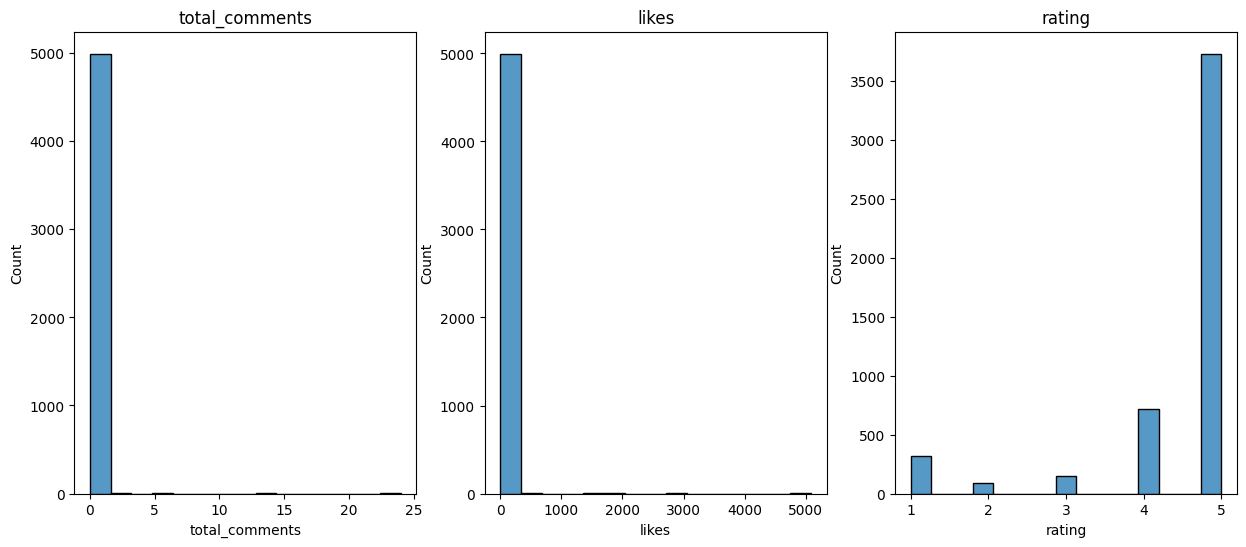

In [17]:
plt.figure(figsize=(15,6))
for idx, col in enumerate(numeric):
    plt.subplot(1, 3, idx+1)
    sns.histplot(df[col], bins=15)
    plt.title(col)

* We can infer that the iPhone XR 64GB model has got majority of 5 star rating
* Very few reviews have comments and likes

In [18]:
for idx, col in enumerate(categoric):
    if col=='review_text' or col=='review_title': continue
    print(f'{df[col].nunique()} unique values found: {df[col].unique()}')

1 unique values found: ['Apple iPhone XR (64GB) - Black']
1 unique values found: [' India ']
1 unique values found: ['Apple']
4097 unique values found: ['Sameer Patil' 'Amazon Customer' 'A' ... 'Shreya' 'murali hv'
 'basil john p']


* For the categoric or the object type columns, there is not much to do since there are single values across 3 of them. So we can go ahead and drop them

In [19]:
df.drop(['product', 'review_country', 'product_company', 'profile_name'], axis=1, inplace=True)

* We combine the 'review_title' and the 'review_text' columns to get the full review of the device

In [20]:
def get_review(x):
    return x.review_title+': '+x.review_text
    
df['full review']=df.apply(get_review, axis=1)

In [21]:
df.drop(['review_text', 'review_title'], axis=1, inplace=True)

([<matplotlib.patches.Wedge at 0x20d1bad3af0>,
 [Text(-1.0645015604617463, 0.2771938451237825, 'Positive'),
  Text(1.0645015799263142, -0.27719377037441, 'Negative')],
 [Text(-0.580637214797316, 0.15119664279479042, '92%'),
  Text(0.5806372254143531, -0.15119660202240542, '8%')])

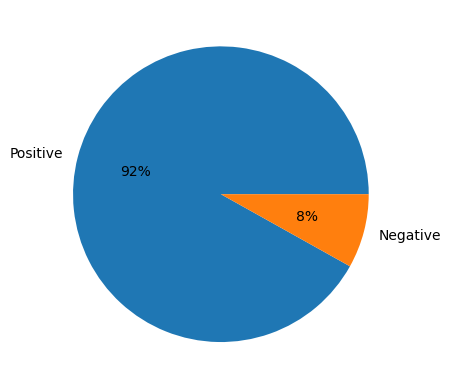

In [22]:
df['sentiment']=np.where(df.rating>=3, 'Positive', 'Negative')
plt.pie(df.sentiment.value_counts(), labels=df.sentiment.unique(), autopct='%.0f%%')

#### This is how our data looks after preprocessing

In [23]:
df.head()

total_comments reviewed_at  likes  rating  \
0              24  2018-12-12   5087     3.0   
1               6  2018-11-17   2822     1.0   
2               0  2019-01-27   1798     5.0   
3              14  2019-05-02   1366     1.0   
4               5  2019-05-24    536     5.0   

                                         full review sentiment  
0  Which iPhone you should Purchase ? iPhone 8, X...  Positive  
1  Don't buy iPhone xr from Amazon.: Very bad exp...  Negative  
2  Happy with the purchase: Amazing phone with am...  Positive  
3  Amazon is not an apple authorised reseller. Pl...  Negative  
4  Excellent Battery life and buttery smooth UI: ...  Positive

* We check correlation among the numeric columns

<Axes: >

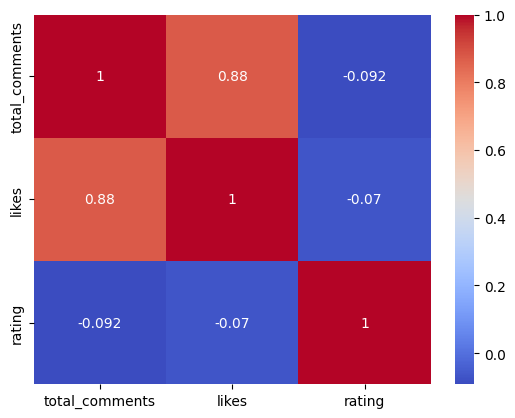

In [24]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Plot heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')

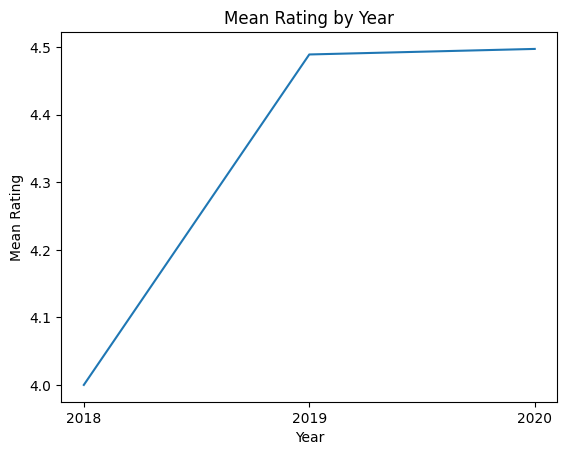

In [25]:
df['reviewed_at'] = pd.to_datetime(df['reviewed_at'])

# Create a new column for the year
df['year'] = df['reviewed_at'].dt.year

# Group by 'year' and calculate the mean of 'rating'
mean_ratings_by_year = df.groupby('year')['rating'].mean()

# Plot the line plot
sns.lineplot(x=mean_ratings_by_year.index, y=mean_ratings_by_year)
plt.xticks(ticks=mean_ratings_by_year.index, labels=mean_ratings_by_year.index.astype(int))
plt.xlabel('Year')
plt.ylabel('Mean Rating')
plt.title('Mean Rating by Year')
plt.show()

In [26]:
data = pd.read_csv("Dataset-SA.csv")
data.head(10)

product_name product_price Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   
3  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    1   
4  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   
5  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
6  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
7  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   
8  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    1   
9  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    4   

               Review                                            Summary  \
0              super!  great cooler excellent air flow and for this p...   
1             awesome              best budget 2 fit cooler nice cooling   
2                fair  the quality is good but the power of air is de...   
3     useless product                  very bad product its a only a fan   
4                fair                                      ok ok product   
5             awesome  the cooler is really fantastic and provides go...   
6  highly recommended                                  very good product   
7                nice                                          very nice   
8      unsatisfactory                                    very bad cooler   
9     worth the money                                          very good   

  Sentiment  
0  positive  
1  positive  
2  positive  
3  negative  
4   neutral  
5  positive  
6  positive  
7  positive  
8  negative  
9  positive

ML Starts

In [27]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Custom transformer class for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        preprocessed_sentences = []
        for sentence in X:
            # Convert text to lowercase
            sentence = sentence.lower()
            
            # Remove white spaces
            sentence = sentence.strip()
            
            # Remove punctuation
            sentence = sentence.translate(str.maketrans('', '', string.punctuation))
            
            # Remove stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = word_tokenize(sentence)
            sentence = ' '.join([word for word in word_tokens if word not in stop_words])
            
            # Perform stemming
            stemmer = PorterStemmer()
            stemmed_sentence = ' '.join([stemmer.stem(word) for word in word_tokens])
            
            # Perform lemmatization
            lemmatizer = WordNetLemmatizer()
            lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])
            
            preprocessed_sentences.append((sentence, stemmed_sentence, lemmatized_sentence))
        
        return preprocessed_sentences

# Initialize custom transformer
text_preprocessor = TextPreprocessor()


In [28]:
# Read the dataset
data = pd.read_csv("Dataset-SA.csv")

# Fill missing values in "Summary" column with a placeholder string
data["Summary"].fillna("", inplace=True)

# Apply custom transformer to the data
X = data["Summary"]
y = data["Sentiment"]
y_uniq=data['Sentiment'].values
preprocessed_data = text_preprocessor.fit_transform(X)

C:\Users\thema\AppData\Local\Temp\ipykernel_17484\2994561610.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Summary"].fillna("", inplace=True)


Vectorizing

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle
vec = CountVectorizer()
X_preprocessed = [sentence[0] for sentence in preprocessed_data]  # Using the preprocessed sentence
matrix_X = vec.fit_transform(X_preprocessed)
pickle.dump(vec, open('models/countVectorizer.pkl', 'wb'))
print(matrix_X)


  (0, 19703)	1
  (0, 11509)	1
  (0, 15615)	1
  (0, 4064)	1
  (0, 17688)	1
  (0, 32547)	1
  (0, 4417)	1
  (0, 43964)	1
  (0, 25175)	1
  (1, 11509)	1
  (1, 7036)	1
  (1, 8322)	1
  (1, 17225)	1
  (1, 28169)	1
  (1, 11541)	1
  (2, 4064)	1
  (2, 34534)	1
  (2, 18998)	1
  (2, 32216)	1
  (2, 12686)	1
  (3, 6102)	1
  (3, 33082)	1
  (3, 16441)	1
  (4, 33082)	1
  (4, 29055)	2
  :	:
  (205043, 6020)	1
  (205044, 41146)	1
  (205045, 34534)	1
  (205045, 18998)	1
  (205045, 33492)	1
  (205046, 28169)	1
  (205046, 6737)	1
  (205046, 38149)	1
  (205047, 18998)	1
  (205047, 33082)	1
  (205048, 28169)	1
  (205049, 28169)	1
  (205049, 12984)	1
  (205049, 16561)	1
  (205050, 33082)	1
  (205050, 5712)	1
  (205051, 18998)	1
  (205051, 29263)	1
  (205051, 38799)	1
  (205051, 39082)	1
  (205051, 21831)	1
  (205051, 39770)	1
  (205051, 7908)	2
  (205051, 26824)	1
  (205051, 13793)	1


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(matrix_X, y, test_size=0.2, stratify=y_uniq, random_state=42)
y_train.value_counts()

Sentiment
positive    133264
negative     22586
neutral       8191
Name: count, dtype: int64

In [31]:
y_test.value_counts()

Sentiment
positive    33317
negative     5646
neutral      2048
Name: count, dtype: int64

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def get_metrics(y_true, y_preds, pred_proba=None):
    print(f'Accuracy Score: {accuracy_score(y_true, y_preds)}')
    if pred_proba is not None:
        print(f'ROC AUC Score: {roc_auc_score(y_true, pred_proba, multi_class="ovo")}')
    print(classification_report(y_true, y_preds))
    plt.figure(figsize=(18, 6))
    sns.heatmap(confusion_matrix(y_true, y_preds), annot=True)


In [33]:
import warnings

# Suppressing the specific warning
warnings.filterwarnings("ignore")


Naive Bayes
Accuracy Score: 0.8902245738948087
              precision    recall  f1-score   support

    negative       0.80      0.68      0.73      5646
     neutral       0.46      0.07      0.12      2048
    positive       0.91      0.98      0.94     33317

    accuracy                           0.89     41011
   macro avg       0.72      0.57      0.60     41011
weighted avg       0.87      0.89      0.87     41011



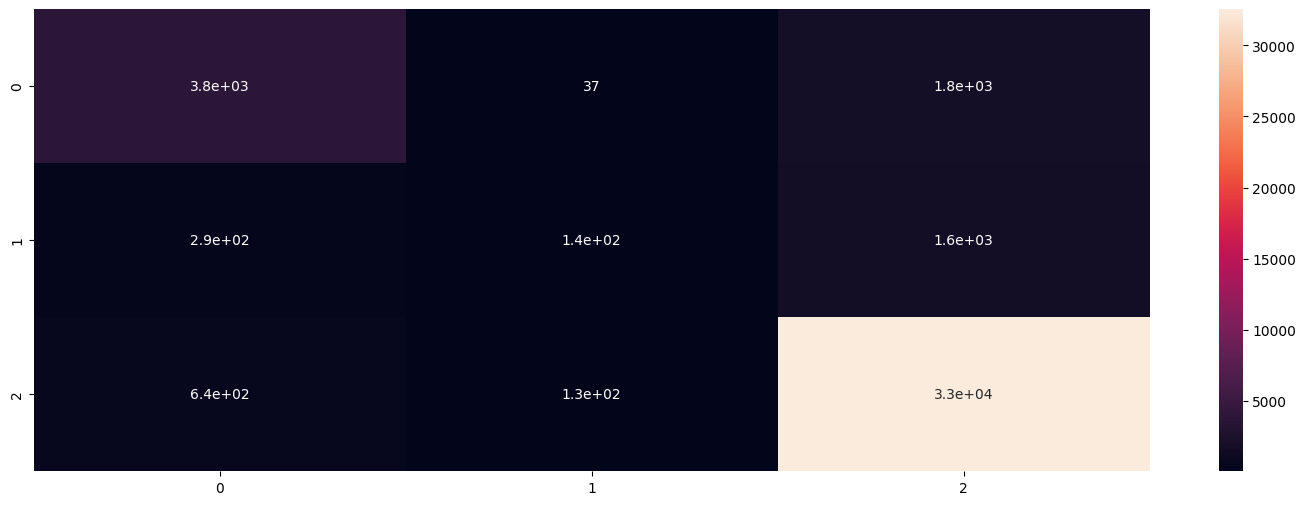

In [34]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes")
get_metrics(y_test, y_pred_nb)


In [35]:
from sklearn.tree import DecisionTreeClassifier

# For Decision Tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree")
get_metrics(y_test, y_pred_dt)

Decision Tree
Accuracy Score: 0.860086318304845
              precision    recall  f1-score   support

    negative       0.87      0.39      0.54      5646
     neutral       0.00      0.00      0.00      2048
    positive       0.86      0.99      0.92     33317

    accuracy                           0.86     41011
   macro avg       0.58      0.46      0.49     41011
weighted avg       0.82      0.86      0.82     41011



In [36]:
from sklearn.linear_model import LogisticRegression

# For Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression")
get_metrics(y_test, y_pred_lr)



Logistic Regression
Accuracy Score: 0.9170222623198654
              precision    recall  f1-score   support

    negative       0.82      0.73      0.78      5646
     neutral       0.67      0.48      0.56      2048
    positive       0.94      0.97      0.96     33317

    accuracy                           0.92     41011
   macro avg       0.81      0.73      0.76     41011
weighted avg       0.91      0.92      0.91     41011



Using pre trained models

In [37]:
!pip install datasets transformers==4.28.0
!pip install --upgrade accelerate

In [38]:
# Import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [39]:
# Load tokenizer and model, create trainer
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

In [40]:
text_column = "Summary"

df_pred = pd.read_csv("Dataset-SA.csv")
pred_texts = df_pred[text_column].dropna().astype('str').tolist()

In [41]:
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [42]:
predictions = trainer.predict(pred_dataset)

KeyboardInterrupt: 

In [ ]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores)), columns=['text','pred','label','score'])
df.head()

End of traning

In [ ]:
import pickle
import os
if not os.path.exists('models'):
    os.makedirs('models')
pickle_file_path = 'models/SA.pkl'

with open(pickle_file_path, 'wb') as f:
    pickle.dump(lr, f)

print("Model saved to", pickle_file_path)


In [ ]:
predictor = pickle.load(open(r"models/SA.pkl", "rb"))
cv=pickle.load(open(r"models/countVectorizers.pkl", "rb"))

In [ ]:
def preprocess_text(input_text):
    # Convert text to lowercase
    text = input_text.lower()
    
    # Remove white spaces
    text = text.strip()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text_no_stopwords = ' '.join([word for word in word_tokens if word not in stop_words])
    
    # Perform stemming
    stemmer = PorterStemmer()
    stemmed_text = ' '.join([stemmer.stem(word) for word in word_tokens])
    
    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])
    
    return lemmatized_text

In [ ]:
import pickle
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

def preprocess_text(input_text):
    # Convert text to lowercase
    text = input_text.lower()
    
    # Remove white spaces
    text = text.strip()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text_no_stopwords = ' '.join([word for word in word_tokens if word not in stop_words])
    
    # Perform stemming
    stemmer = PorterStemmer()
    stemmed_text = ' '.join([stemmer.stem(word) for word in word_tokens])
    
    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])
    
    return lemmatized_text

# Load the trained model and CountVectorizer
predictor = pickle.load(open("models/SA.pkl", "rb"))
cv = pickle.load(open("models/countVectorizer.pkl", "rb"))

# Sample text for prediction
sample = "None of the product was a great"
preprocessed_text = preprocess_text(sample)
X_prediction = cv.transform([preprocessed_text]).toarray()

# Make prediction
y_predictions = predictor.predict_proba(X_prediction)
y_predictions = y_predictions.argmax(axis=1)[0]

# Output prediction
print(y_predictions)

Aspect Based Sentiment Analysis

In [ ]:
df = pd.read_csv('data.csv')
df

In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
from sklearn.model_selection import KFold, GridSearchCV ,ParameterGrid
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv('data.csv')

# Preprocess the data
def preprocess_text(text):
    words = nltk.tokenize.word_tokenize(text.lower())
    allowed_tags = ['VBP', 'VB', 'VBG', 'JJ', 'NN', 'RB']
    words_tags = nltk.pos_tag(words)
    processed_words = [w for w, t in words_tags if t in allowed_tags]
    return ' '.join(processed_words)

df['processed_text'] = df['text'].apply(preprocess_text)

# Extract X (processed text) and y (polarities)
X = df['processed_text']
y = df['polarities']  # Assuming 'polarities' contains sentiment polarities

# Train Word2Vec Skip-gram model
sentences = [nltk.word_tokenize(text) for text in X]

# Function to average Word2Vec vectors for each aspect term
def average_word_vectors(words, model):
    feature_vector = np.zeros((model.vector_size,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in model.wv.index_to_key:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

# Define the parameter grid for Word2Vec
param_grid_word2vec = {
    'vector_size': [50, 100, 200],  # Dimensionality of word vectors
    'window': [3, 5, 7],  # Context window size
    'min_count': [1, 5, 10]  # Minimum frequency threshold for words
}

# Generate all combinations of parameters
param_combinations = ParameterGrid(param_grid_word2vec)

# Evaluate each combination
best_accuracy = 0
best_params_word2vec = {}
for params in param_combinations:
    # Train Word2Vec model with current parameters
    skipgram_model = Word2Vec(sentences, **params, sg=1)
    
    # Transform text into Word2Vec embeddings
    X_word2vec = [average_word_vectors(nltk.word_tokenize(text), skipgram_model) for text in X]
    
    # Perform K-Fold Cross-Validation with SVM classifier (code not shown)
    # Compute accuracy
    
    # Update best parameters if current accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params_word2vec = params

# Print the best parameters
print("Best Parameters for Word2Vec:", best_params_word2vec)

# Initialize LDA model
lda_model = LatentDirichletAllocation(random_state=42)

# Define the parameter grid for LDA
param_grid_lda = {
    'n_components': [5, 10, 15],  # Try different numbers of topics
    'learning_decay': [0.5, 0.7, 0.9],  # Learning decay parameter
    'max_iter': [10, 50, 100]  # Maximum number of iterations
}

# Vectorize the processed text
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Perform grid search cross-validation
lda_grid_search = GridSearchCV(lda_model, param_grid_lda, cv=3)
lda_grid_search.fit(X_vectorized)

# Print the best parameters
print("Best Parameters for LDA:", lda_grid_search.best_params_)

# Get the best LDA model from the grid search
best_lda_model = lda_grid_search.best_estimator_

# Apply LDA to extract topics from the text data
X_lda = best_lda_model.transform(X_vectorized)

# Combine Word2Vec embeddings and LDA topics
X_combined = np.concatenate([X_word2vec, X_lda], axis=1)

# Split data for K-Fold Cross-Validation
kf = KFold(n_splits=10)
accuracy_scores = []

for train_index, test_index in kf.split(X_combined):
    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train SVM classifier
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    
    # Predict sentiment polarities
    y_pred = svm.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    accuracy_scores.append(accuracy)

# Calculate average accuracy across all folds
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy:", average_accuracy)


In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn


# Function to preprocess the text and remove unwanted words and punctuation
def preprocess_text(text):
    words = nltk.tokenize.word_tokenize(text.lower())
    allowed_tags = ['VBP', 'VB', 'VBG', 'JJ', 'NN', 'RB']
    words_tags = nltk.pos_tag(words)
    processed_words = [w for w, t in words_tags if t in allowed_tags]
    return ' '.join(processed_words)

# Load the dataset
df = pd.read_csv('data.csv')

# Preprocess the data
df['processed_text'] = df['text'].apply(preprocess_text)

# Extract X (processed text) and y (polarities)
X = df['processed_text']
y = df['polarities']  # Assuming 'polarities' contains sentiment polarities

# Train Word2Vec model with best parameters
sentences = [nltk.word_tokenize(text) for text in X]
best_word2vec_params = {'min_count': 1, 'vector_size': 50, 'window': 3}
skipgram_model = Word2Vec(sentences, **best_word2vec_params, sg=1)

# Transform text into Word2Vec embeddings
X_word2vec = [average_word_vectors(nltk.word_tokenize(text), skipgram_model) for text in X]

# Initialize LDA model with best parameters
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

best_lda_params = {'learning_decay': 0.5, 'max_iter': 100, 'n_components': 5}
best_lda_model = LatentDirichletAllocation(**best_lda_params, random_state=42)

# Apply LDA to extract topics from the text data
X_lda = best_lda_model.fit_transform(X_vectorized)

# Printing the top words for each topic
feature_names = vectorizer.get_feature_names_out()
topic_words = {}
for topic_idx, topic in enumerate(best_lda_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    topic_words[topic_idx] = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {' '.join([feature_names[i] for i in top_words_idx])}")

# Extracting top 10 noun features for each topic
noun_features = {}
for topic_idx, words in topic_words.items():
    nouns = [word for word in words if nltk.pos_tag([word])[0][1] == 'NN'][:10]
    noun_features[topic_idx] = nouns
    print(f"Top Noun Features for Topic {topic_idx + 1}: {', '.join(nouns)}")

# Sentiment values for each topic
# Sentiment values for each topic
sentiment_values = {}
for topic_idx, words in topic_words.items():
    score = 0
    for w in words:
        synsets = wn.synsets(w)
        if synsets:  # Check if synsets exist for the word
            senti_synset = swn.senti_synset(synsets[0].name())
            score += senti_synset.pos_score() - senti_synset.neg_score()
    sentiment_values[topic_idx] = score
    print(f"Sentiment value for Topic {topic_idx + 1}: {sentiment_values[topic_idx]}")


# Combine Word2Vec embeddings and LDA topics
X_combined = np.concatenate([X_word2vec, X_lda], axis=1)

# Split data for K-Fold Cross-Validation
kf = KFold(n_splits=10)
accuracy_scores = []

for train_index, test_index in kf.split(X_combined):
    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train SVM classifier
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    
    # Predict sentiment polarities
    y_pred = svm.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    accuracy_scores.append(accuracy)

# Calculate average accuracy across all folds
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy:", average_accuracy)


In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix


# Function to preprocess the text and remove unwanted words and punctuation
def preprocess_text(text):
    words = nltk.tokenize.word_tokenize(text.lower())
    allowed_tags = ['VBP', 'VB', 'VBG', 'JJ', 'NN', 'RB']
    words_tags = nltk.pos_tag(words)
    processed_words = [w for w, t in words_tags if t in allowed_tags]
    return ' '.join(processed_words)

# Load the dataset
df = pd.read_csv('data.csv')

# Preprocess the data
df['processed_text'] = df['text'].apply(preprocess_text)

# Extract X (processed text) and y (polarities)
X = df['processed_text']
y = df['polarities']  # Assuming 'polarities' contains sentiment polarities

# Train Word2Vec model with best parameters
sentences = [nltk.word_tokenize(text) for text in X]
best_word2vec_params = {'min_count': 1, 'vector_size': 50, 'window': 3}
skipgram_model = Word2Vec(sentences, **best_word2vec_params, sg=1)

# Transform text into Word2Vec embeddings
X_word2vec = [average_word_vectors(nltk.word_tokenize(text), skipgram_model) for text in X]

# Initialize LDA model with best parameters
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

best_lda_params = {'learning_decay': 0.5, 'max_iter': 100, 'n_components': 5}
best_lda_model = LatentDirichletAllocation(**best_lda_params, random_state=42)

# Apply LDA to extract topics from the text data
X_lda = best_lda_model.fit_transform(X_vectorized)

# Printing the top words for each topic
feature_names = vectorizer.get_feature_names_out()
topic_words = {}
for topic_idx, topic in enumerate(best_lda_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    topic_words[topic_idx] = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {' '.join([feature_names[i] for i in top_words_idx])}")

# Extracting top 10 noun features for each topic
noun_features = {}
for topic_idx, words in topic_words.items():
    nouns = [word for word in words if nltk.pos_tag([word])[0][1] == 'NN'][:10]
    noun_features[topic_idx] = nouns
    print(f"Top Noun Features for Topic {topic_idx + 1}: {', '.join(nouns)}")

# Sentiment values for each topic
# Sentiment values for each topic
sentiment_values = {}
for topic_idx, words in topic_words.items():
    score = 0
    for w in words:
        synsets = wn.synsets(w)
        if synsets:  # Check if synsets exist for the word
            senti_synset = swn.senti_synset(synsets[0].name())
            score += senti_synset.pos_score() - senti_synset.neg_score()
    sentiment_values[topic_idx] = score
    print(f"Sentiment value for Topic {topic_idx + 1}: {sentiment_values[topic_idx]}")


# Combine Word2Vec embeddings and LDA topics
X_combined = np.concatenate([X_word2vec, X_lda], axis=1)

# Split data for K-Fold Cross-Validation
kf = KFold(n_splits=10)
accuracy_scores = []

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

def get_metrics(y_true, y_preds, pred_proba=None):
    print(f'Accuracy Score: {accuracy_score(y_true, y_preds)}')
    if pred_proba is not None:
        print(f'ROC AUC Score: {roc_auc_score(y_true, pred_proba, multi_class="ovo")}')
    print(classification_report(y_true, y_preds))
    plt.figure(figsize=(18, 6))
    sns.heatmap(confusion_matrix(y_true, y_preds), annot=True)

# Inside your cross-validation loop
for train_index, test_index in kf.split(X_combined):
    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train SVM classifier for multiclass classification
    svm = SVC(kernel='linear', probability=True, decision_function_shape='ovr')  # Use 'ovr' for multiclass classification
    svm.fit(X_train, y_train)
    
    # Predict sentiment polarities
    y_pred = svm.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Get probability estimates for each class
    y_pred_proba = svm.predict_proba(X_test)
    
    # Print metrics and confusion matrix
    get_metrics(y_test, y_pred, pred_proba=y_pred_proba)



# Calculate average accuracy across all folds
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy:", average_accuracy)


In [ ]:
df = pd.read_csv('data.csv')
df

In [ ]:
s=" s po r "
p=s.strip(" ")
p


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load BERT model from TensorFlow Hub
bert_model_hub = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
bert_layer = hub.KerasLayer(bert_model_hub, trainable=True)

# Load dataset (replace this with your dataset loading code)
# Example data: text and labels
texts = ["I really like this product", "This movie is terrible", "Great experience, highly recommended"]
labels = [1, 0, 1]  # 1 for positive, 0 for negative

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize text data
def tokenize_text(texts):
    input_ids = []
    input_masks = []
    input_segments = []
    for text in texts:
        bert_input = bert_tokenizer.encode_plus(text, add_special_tokens=True, max_length=128, pad_to_max_length=True, return_attention_mask=True)
        input_ids.append(bert_input['input_ids'])
        input_masks.append(bert_input['attention_mask'])
        input_segments.append([0] * 128)  # BERT only needs one segment, so it's always 0
    return np.array(input_ids), np.array(input_masks), np.array(input_segments)

# Tokenize training and testing data
X_train_ids, X_train_masks, X_train_segments = tokenize_text(X_train)
X_test_ids, X_test_masks, X_test_segments = tokenize_text(X_test)

# Define input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
input_masks = Input(shape=(128,), dtype=tf.int32, name="input_masks")
input_segments = Input(shape=(128,), dtype=tf.int32, name="input_segments")

# BERT layer
bert_inputs = [input_ids, input_masks, input_segments]
bert_output = bert_layer(bert_inputs)

# Add classification layer
output = Dense(1, activation='sigmoid')(bert_output)

# Create model
model = Model(inputs=bert_inputs, outputs=output)

# Compile model
optimizer = Adam(lr=2e-5)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train model
model.fit([X_train_ids, X_train_masks, X_train_segments], y_train, epochs=3, batch_size=32, validation_split=0.1)

# Evaluate model
loss, accuracy = model.evaluate([X_test_ids, X_test_masks, X_test_segments], y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Load dataset
data = pd.read_csv('data.csv')

# Preprocessing function
def preprocess(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lowercasing and removing stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    return stemmed_tokens

# Apply preprocessing to text column
data['preprocessed_text'] = data['text'].apply(preprocess)

# Transform data into word embeddings (using Word2Vec as an example)
sentences = data['preprocessed_text'].tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save or load Word2Vec model
word2vec_model.save('word2vec_model.bin')
# word2vec_model = Word2Vec.load('word2vec_model.bin')

# Example usage of Word2Vec model
vector = word2vec_model.wv['example_word']
